Author: Carlos Roberto de Melo

Obj: MGE parametrization for pseudo-NFW profile,  eq. S1 of 10.1126/science.aao2469

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from mgefit import mge_fit_1d                                       #MGE 1-d parametrization
from jampy.mge_half_light_isophote import mge_half_light_isophote   #Compute half light radius
from jampy.mge_half_light_isophote import mge_half_light_radius     #Compute half light radius (other way)

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import table

In [173]:
#Reading MGE parametrization
surf, sigma, qobs = np.loadtxt("JAM_Input.txt", unpack=True)
#Fris we will computhe the half ligth radius for the MGE parametrization

In [174]:
#Distance to the galaxy in Mpc
z        = 0.299                                  #Galaxy redshift
distance = cosmo.angular_diameter_distance(z)     #Distance to galaxy [Mpc]
distance

<Quantity 945.37739581 Mpc>

In [208]:
#Computing the half-light radius
reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(
                    surf, sigma, qobs, distance=distance)
reff_arc = reff*u.arcsec
reff_pc  = (reff_arc*distance).to(u.pc, u.dimensionless_angles())

print("Half-light radius, the  major axis and ellipticity of \n"+
              "the MGE isophote containing 1/2 of the analytic MGE total light.")

print(reff_arc)
print(reff_pc)

Half-light radius, the  major axis and ellipticity of 
the MGE isophote containing 1/2 of the analytic MGE total light.
1.197087592740062 arcsec
5486.634252210675 pc


In [209]:
##Computing the half-light radius using other approach
reff2, lum_tot2 = mge_half_light_radius(surf, sigma, qobs, distance)

print("Computes the circularized projected half-light radius of an \n"+
       "MGE model using the approach described after equation (11)\n"+
        "in Cappellari et al. (2013, MNRAS, 432, 1709)")

reff2_arc = reff2*u.arcsec
reff2_pc  = (reff2_arc*distance).to(u.pc, u.dimensionless_angles())

print(reff2_arc)
print(reff2_pc)

Computes the circularized projected half-light radius of an 
MGE model using the approach described after equation (11)
in Cappellari et al. (2013, MNRAS, 432, 1709)
1.1876279376508265 arcsec
5443.277635751308 pc


In [210]:
#pseudo-NFW profile

def pNFW(rho_0, r_s, r):
    """
    Input:
    -------------
        rho_s: scalar [M_sun] 
            Density scale
        r_s  : scalar [pc] 
            Scale radius
        r    : array [pc] 
            Radius
    """
    rho = rho_0/(r*(r_s**2 + r**2))
    return rho



In [253]:
#pseudo-NFW input parameters

r_s   =  reff_pc.value           #scale radius, as recomended by reference [pc]
print(r_s)
rho_0 = 5e9                          #scale density [M_solar]

#Now we set the radius were we want to compute the parametrization. This radius is
 #log spaced because mge_1d_fit is designed in that way.
r     = np.logspace(-2.5, 3.7358, 300) #[pc]

5486.634252210675


In [255]:
r.max() - r_s

-44.11467387863104

    We are setting rho_0 equal to one, because we want to use this profile with Emcee, to find the best rho_0.
    And for this propose, at each Emcee interaction, the pseudo-NFW profile will be scaled by a rho_0. So, we need a generic parametrization were only the intensity (aka rho_s) are updated.
    We also gives it a generic axial ratio, because the axial ratio is the other free parameter during Emcee search.

Text(0, 0.5, 'Density [M_sun/pc3]')

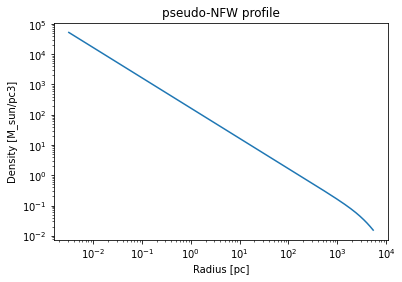

In [256]:
#First we sampled the profile, and plot it for visual inspection
pseudo_NFW = pNFW(rho_0=rho_0, r_s=r_s, r=r)

plt.loglog(r, pseudo_NFW)
plt.title("pseudo-NFW profile")
plt.xlabel("Radius [pc]")
plt.ylabel("Density [M_sun/pc3]")

Iteration: 1  chi2: 1.507 Nonzero: 19/20
Iteration: 11  chi2: 0.01928 Nonzero: 20/20
Iteration: 21  chi2: 0.0187 Nonzero: 20/20
Iteration: 31  chi2: 0.01866 Nonzero: 20/20
Iteration: 41  chi2: 0.01864 Nonzero: 20/20
Iteration: 51  chi2: 0.01864 Nonzero: 20/20
Iteration: 61  chi2: 0.01864 Nonzero: 20/20
Iteration: 71  chi2: 0.01863 Nonzero: 20/20
Iteration: 81  chi2: 0.01863 Nonzero: 20/20
Iteration: 91  chi2: 0.01863 Nonzero: 20/20
Iteration: 101  chi2: 0.01863 Nonzero: 20/20
Iteration: 102  chi2: 0.01863 Nonzero: 20/20
############################################
 Computation time: 1.69 seconds
 Total Iterations:  102
Nonzero Gaussians:  20
 Unused Gaussians:  0
 Chi2: 0.01863 
 STDEV: 0.007881
 MEANABSDEV: 0.003339
############################################
 Total_Counts      Sigma
############################################
      264.157   0.00223607
      253.396    0.0048544
      250.132    0.0103508
      248.227     0.021913
      246.495    0.0461412
      244.799    0.0966

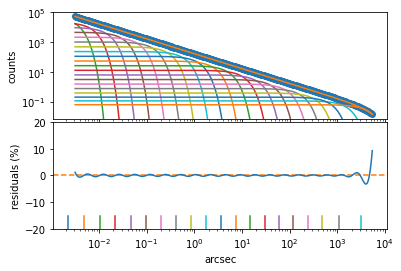

In [257]:
#Finally we set the MGE parametrization
mge = mge_fit_1d.mge_fit_1d(r, pseudo_NFW, ngauss=20,quiet=False, plot=True)

Now we save our parameterization

In [258]:
mge_peak  = mge.sol[0]                         #Gaussian peak        [M_sun/pc2]
mge_sigma = mge.sol[1]                         #Gaussian sigma       [pc]
mge_qobs  = np.full_like(mge_peak, 0.74)        #Gaussian axial ratio [ad] **Remember, this is a arbitrary value**

In [259]:
np.savetxt('SDP81_pseudo-DM_halo-test.txt', np.column_stack([mge_peak, mge_sigma/(distance.value*np.pi/0.648), mge_qobs]),
                            fmt=b'%5.5e\t\t\t %5.5e\t\t %5.5e', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

#Here, when we save the sigma of each Gaussian we divide by the value (distance * np.pi / 0.648)
 #because the JAM requires that sigma be given in arcsec.

## Total DM Mass

In [260]:
#Reading MGE parametrization
import mgetools as mge
#surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SDP81_pseudo-DM_halo-test.txt", unpack=True)    #DM component
mge2d                         = table.QTable.read("SDP81_pseudo-DM_halo-test.txt", format="ascii")    #DM component

In [261]:
mge2d

i,s,q
solMass / pc2,arcsec,
float64,float64,float64
264.157,4.87871e-07,0.74
253.396,1.05915e-06,0.74
250.132,2.25836e-06,0.74
248.227,4.78103e-06,0.74
246.495,1.00672e-05,0.74
244.799,2.10891e-05,0.74
243.127,4.39548e-05,0.74
241.477,9.11553e-05,0.74


In [262]:
#Transforming Surf Density to Total Mass
surf_dm      = surf_dm * u.solMass/u.pc**2
sigma_dm_ARC = sigma_dm * u.arcsec           #sigma in arcsec
sigma_dm_PC  = (sigma_dm_ARC * distance).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc

#sigma_dm_ARC = sigma_dm_ARC.value
#sigma_dm_PC  = sigma_dm_PC.value

#Convert surf_DM mass total mass per Guassian 
    #Total DM mass per gaussian in M_sun
Mass_DM = 2 * np.pi * surf_dm * (sigma_dm_PC**2) * qobs_dm


In [263]:
Mass_DM

<Quantity [4.20737955e-08, 1.88747892e-07, 8.39890193e-07, 3.70144899e-06,
           1.61603066e-05, 7.00401776e-05, 3.02117065e-04, 1.29996772e-03,
           5.58569717e-03, 2.39134506e-02, 1.01009194e-01, 4.16086626e-01,
           1.66065651e+00, 4.71464014e+00, 1.18509557e+01] solMass>

In [112]:
Mass_DM.sum()

<Quantity 18.77454041 solMass>

Let's deproject this, assuming an inclination of 80 deg and a distance of 945.3774 Mpc.

In [264]:
mge3d = mge.Deproject(mge2d, inclination=60*u.deg, distance=distance)
print(mge3d)

         i                    s                   q         
   solMass / pc3              pc                            
------------------- --------------------- ------------------
  55364.70537174383 0.0022360684009206946 0.6299206299209448
  24463.47553395905  0.004854422269073492 0.6299206299209448
 11325.358429331738  0.010350784190704633 0.6299206299209448
  5308.886281980072   0.02191298541387758 0.6299206299209448
  2503.659653174938   0.04614118856367527 0.6299206299209448
  1186.936448050258   0.09665807173178283 0.6299206299209448
  565.5913461933984   0.20145886791547138 0.6299206299209448
 270.87549627706596   0.41779381415670575 0.6299206299209448
  130.3764330074781     0.862177294887365 0.6299206299209448
  63.06115119490223     1.770581944734722 0.6299206299209448
  30.64999770160461      3.61868156292159 0.6299206299209448
 14.968406607537416     7.360810238523371 0.6299206299209448
  7.344614859742265    14.902890741638025 0.6299206299209448
 3.6206945735735316    3

## Surface Density

First let's plot the surface density map in two dimensions (x and y) for the projected (2d) MGE.

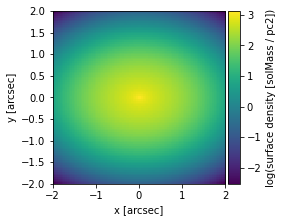

In [267]:
# full grid of R and z values, linear spacing
xy = np.linspace(-2, 2, 100)
x, y = np.meshgrid(xy, xy)*u.arcsec

# calculate surface density
surface_density = mge.SurfaceDensity(mge2d, x, y)

# plot log surface density map
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0.20, 0.15, 0.60, 0.80])
plt.xlabel("x [{:}]".format(x.unit))
plt.ylabel("y [{:}]".format(y.unit))
cols = plt.imshow(np.log10(surface_density.value), origin="lower", aspect="equal", interpolation="nearest",
           extent=(x.min().value, x.max().value, y.min().value, y.max().value))
cax = fig.add_axes([0.81, 0.15, 0.04, 0.80])
plt.colorbar(cols, cax=cax, orientation="vertical")
plt.ylabel("log(surface density [{:}])".format(surface_density.unit))
plt.show()

And now let's look at the surface densities along the major (x) and minor (y) axes. These are not identical as the system is flattened.

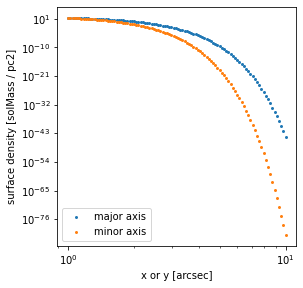

In [269]:
# quarter grid of R and z values, log spacing
log_xy = np.logspace(0, 1, 100)
log_x, log_y = np.meshgrid(log_xy, log_xy)*u.arcsec

# calculate surface density
surface_density = mge.SurfaceDensity(mge2d, log_x, log_y)

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.scatter(log_x[0], surface_density[0], s=9, lw=0, label="major axis")
plt.scatter(log_y[:,0], surface_density[:,0], s=9, lw=0, label="minor axis")
plt.legend()
plt.xlabel("x or y [{:}]".format(log_x.unit))
plt.ylabel("surface density [{:}]".format(surface_density.unit))
plt.show()



## Volume Density

Now we consider the deprojected (3d) MGE. Again, let's start with the two dimensional density map in (R and z).

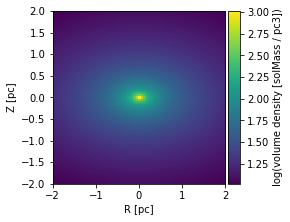

In [270]:
# full grid of R and z values, linear spacing
Rz = np.linspace(-10, 10, 100)
R, z = np.meshgrid(Rz, Rz)*u.pc

# calculate volume density
volume_density = mge.VolumeDensity(mge3d, R, z)

# plot log volume density map
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0.20, 0.15, 0.60, 0.80])
plt.xlabel("R [{:}]".format(R.unit))
plt.ylabel("Z [{:}]".format(z.unit))
cols = plt.imshow(np.log10(volume_density.value), origin="lower", aspect="equal", interpolation="nearest",
           extent=(x.min().value, x.max().value, y.min().value, y.max().value))
cax = fig.add_axes([0.81, 0.15, 0.04, 0.80])
plt.colorbar(cols, cax=cax, orientation="vertical")
plt.ylabel("log(volume density [{:}])".format(volume_density.unit))
plt.show()

Again, we can also look at the density along the R and z axes separately, which is are slightly different due to the flattening of the MGE.

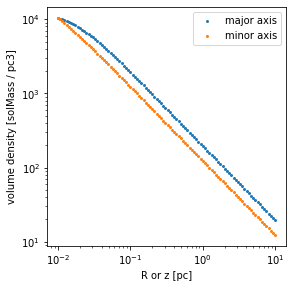

In [271]:
# quarter grid of R and z values, log spacing
log_Rz = np.logspace(-2, 1, 100)
log_R, log_z = np.meshgrid(log_Rz, log_Rz)*u.pc

# calculate volume density
volume_density = mge.VolumeDensity(mge3d, log_R, log_z)

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.scatter(log_R[0], volume_density[0], s=9, lw=0, label="major axis")
plt.scatter(log_z[:,0], volume_density[:,0], s=9, lw=0, label="minor axis")
plt.legend()
plt.xlabel("R or z [{:}]".format(log_R.unit))
plt.ylabel("volume density [{:}]".format(volume_density.unit))
plt.show()

## 3D CumulativeProfile


And the cumulative profile for a deprojected (3d) MGE.

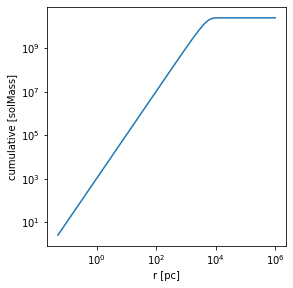

In [272]:
# array grid of radii, log spacing
r = np.logspace(-1.3, 6, 100)*u.pc

# calculate cumulative profile
cumulative = mge.Cumulative3D(r, mge3d)

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.plot(r, cumulative)
plt.xlabel("r [{:}]".format(r.unit))
plt.ylabel("cumulative [{:}]".format(cumulative.unit))
plt.show()


-----------------------------------------------------------------------------------------------------------------

##  Hernquist Model

In this example/test we fit a one dimensional MGE to the density
    of a Hernquist (1990, ApJ, 356, 359; hereafter H90) model.
    
<center> $\rho(r) = \frac{M}{2 \pi} \frac{a}{r} \frac{1}{(r + a)^3}$

In [2]:
def Hern_model(M, a, r):
    return  M*a/(2*np.pi*r*(r+a)**3)  # Density in Msun/pc**3 (H90 equation 2)

In [23]:
M = 1e11          # Total mass in Solar Masses
a = 1e3           # Break radius in pc
distance = 16.5   # Assume Virgo distance in Mpc (Mei et al. 2007)
pc = distance*np.pi/0.648 # Constant factor to convert arcsec --> pc

n = 300  # Number of values to sample the H90 profile for the fit
r = np.logspace(-2.5, 2, n)*a   # logarithmically spaced radii in pc
rho = Hern_model(M, a, r)  # Density in Msun/pc**3 (H90 equation 2)   


Text(0.5, 1.0, 'Hernquist Profile')

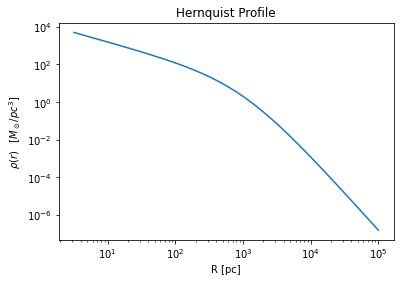

In [24]:
plt.loglog(r, rho)
plt.xlabel("R [pc]")
plt.ylabel("$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]")
plt.title("Hernquist Profile")

Iteration: 1  chi2: 0.1294 Nonzero: 16/16
Iteration: 11  chi2: 0.009084 Nonzero: 16/16
Iteration: 17  chi2: 0.008831 Nonzero: 16/16
############################################
 Computation time: 0.25 seconds
 Total Iterations:  17
Nonzero Gaussians:  16
 Unused Gaussians:  0
 Chi2: 0.008831 
 STDEV: 0.005425
 MEANABSDEV: 0.004835
############################################
 Total_Counts      Sigma
############################################
      26636.3      2.35236
      26083.9      5.37115
      25755.2       12.135
      25132.5      27.0696
      23773.5      59.0015
      20857.2      123.618
      15605.9      245.405
      9042.77      462.013
      3899.01      837.222
      1294.58      1483.05
      353.998      2594.09
      85.0293      4504.72
      18.8555      7787.97
      4.00511      13454.9
     0.838543      23728.3
     0.155362      48307.8
############################################


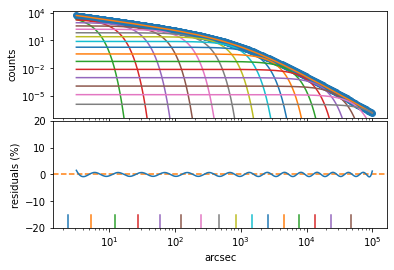

In [25]:
m = mge_fit_1d.mge_fit_1d(r, rho, ngauss=16, plot=True)

In [26]:
surf = m.sol[0]                     # Surface density in Msun/pc**2
sigma = m.sol[1]/pc                 # Gaussian dispersion in arcsec
qObs = np.full_like(surf, 1)        # Assume spherical model


In [27]:
#Transforming Surf Density to Total Mass
distance = 16.5 * u.Mpc                # Assume Virgo distance in Mpc (Mei et al. 2007)
surf_hern      = surf * u.solMass/u.pc**2
sigma_ARC = sigma * u.arcsec           #sigma in arcsec
sigma_PC  = (sigma_ARC * distance).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc

#sigma_dm_ARC = sigma_dm_ARC.value
#sigma_dm_PC  = sigma_dm_PC.value

#Convert surf_DM mass total mass per Guassian 
    #Total DM mass per gaussian in M_sun
Mass = 2 * np.pi * surf_hern * (sigma_PC**2) * qObs

In [273]:
Mass.sum()

<Quantity 9.85579359e+10 solMass>

-----------------------------------------------------------------------------------------------------------------

## Sperical NFW

The classical spherical NFW profile is:
<center> $\rho(r) = \frac{\rho_s}{(r/r_s)  (1 + r/r_s)^2 }$.
    
    
But in terms of the critical surface density,
<center> $\Sigma_{crit} = \frac{c^2}{4\pi G} \frac{D_l}{D_l D_{ls}}$    
    
we have:
<center> $\rho(r) = \frac{\kappa_s \Sigma_{crit}}{r(1 + r/r_s)^2 }$,

where: $\kappa_s = \frac{\rho_s r_s}{\Sigma_{crit}}$.

In [13]:
from astropy.cosmology import Planck15
from astropy.constants import G, M_sun, c
import astropy.units as u
from scipy.integrate import quad

In [5]:
def Sph_NFW(rho_s, r_s, r):
    return rho_s / ( (r/r_s) * (1 + r/r_s)**2 )


def Sph_NFW_lens(kappa_s, r_s, den_crit, r):
    return (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )

def Sph_NFW_lens_integral(r,
                          kappa_s, r_s, den_crit):
    return 4* np.pi * r**2 * (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )
    

In [6]:
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [7]:
#Redshift
z_l = 0.299 
z_s = 3.100

#Angular diametre distances
D_l  = Planck15.angular_diameter_distance(z_l)
D_s  = Planck15.angular_diameter_distance(z_s)
D_ls = Planck15.angular_diameter_distance_z1z2(z_l, z_s)

critical_density = ((c_Mpc**2/(4*np.pi*G_Mpc)) * (D_s/(D_ls * D_l))).to(u.solMass/u.pc**2)

In [377]:
kappa_s = 0.078
r_s     = ( (10 * 1.15 * u.arcsec) * D_l ).to(u.pc, u.dimensionless_angles())

r = np.logspace(-2.5, 3.962, 300) #pc

In [378]:
print("Max: %.3e arcs, Min: %.3e arcs" %( r.max()/(D_l.value*np.pi/0.648), r.min()/(D_l.value*np.pi/0.648)))

Max: 1.999e+00 arcs, Min: 6.900e-07 arcs


Text(0, 0.5, '$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]')

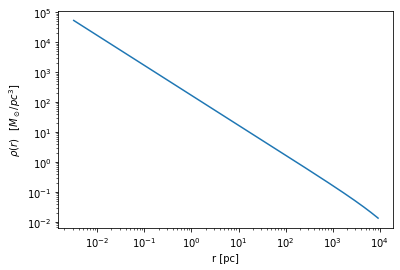

In [379]:
NFW_profile_lens = Sph_NFW_lens(kappa_s, r_s.value, critical_density.value, r)
plt.loglog(r, NFW_profile_lens)
plt.xlabel("r [pc]")
plt.ylabel("$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]")

In [380]:
Mass, err = quad(Sph_NFW_lens_integral, r.min(),r.max(), args=(kappa_s, r_s.value, critical_density.value))
print("Total mass between [%.3e, %.3e]pc: %.3e M_sun$"% (r.min(), r.max(), Mass))

Total mass between [3.162e-03, 9.162e+03]pc: 7.169e+10 M_sun$


Iteration: 1  chi2: 0.712 Nonzero: 19/20
Iteration: 11  chi2: 0.009872 Nonzero: 20/20
Iteration: 21  chi2: 0.009706 Nonzero: 20/20
Iteration: 31  chi2: 0.009626 Nonzero: 20/20
Iteration: 41  chi2: 0.009586 Nonzero: 20/20
Iteration: 51  chi2: 0.009565 Nonzero: 20/20
Iteration: 61  chi2: 0.009554 Nonzero: 20/20
Iteration: 71  chi2: 0.009548 Nonzero: 20/20
Iteration: 81  chi2: 0.009544 Nonzero: 20/20
Iteration: 91  chi2: 0.009543 Nonzero: 20/20
Iteration: 101  chi2: 0.009542 Nonzero: 20/20
Iteration: 111  chi2: 0.009541 Nonzero: 20/20
Iteration: 121  chi2: 0.009541 Nonzero: 20/20
Iteration: 131  chi2: 0.009541 Nonzero: 20/20
Iteration: 141  chi2: 0.009541 Nonzero: 20/20
Iteration: 148  chi2: 0.009541 Nonzero: 20/20
############################################
 Computation time: 2.29 seconds
 Total Iterations:  148
Nonzero Gaussians:  20
 Unused Gaussians:  0
 Chi2: 0.009541 
 STDEV: 0.005639
 MEANABSDEV: 0.003477
############################################
 Total_Counts      Sigma
######

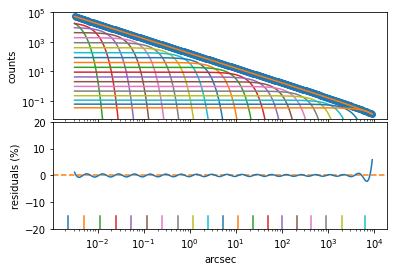

In [381]:
m = mge_fit_1d.mge_fit_1d(r, NFW_profile_lens, ngauss=20, outer_slope=2, plot=True)

In [382]:
surf =  m.sol[0]                           # Surface density in Msun/pc**2
sigma = m.sol[1]/(D_l.value*np.pi/0.648)  # Gaussian dispersion in arcsec
qObs = np.full_like(surf, 1.0)           # Assume spherical model

In [383]:
#Transforming Surf Density to Total Mass
distance  = D_l               # Distance in Mpc
surf_dm = surf * u.solMass/u.pc**2
sigma_ARC = sigma * u.arcsec           #sigma in arcsec
sigma_PC  = (sigma_ARC * distance).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc



#Convert surf_DM mass total mass per Guassian 
    #Total DM mass per gaussian in M_sun
Mass = 2 * np.pi * surf_dm * (sigma_PC**2) * qObs

In [384]:
Mass

<Quantity [8.89129823e-03, 4.34864800e-02, 2.11796281e-01, 1.01976495e+00,
           4.85389277e+00, 2.28433179e+01, 1.06310710e+02, 4.89340457e+02,
           2.22805229e+03, 1.00363923e+04, 4.47316406e+04, 1.97271033e+05,
           8.60813007e+05, 3.71584766e+06, 1.58595760e+07, 6.69147756e+07,
           2.81376406e+08, 1.25563703e+09, 7.51465818e+09, 1.46282164e+11] solMass>

In [376]:
Mass.sum()

<Quantity 1.55421443e+11 solMass>

In [385]:
Mass.sum()

<Quantity 1.55421442e+11 solMass>

In [371]:
from jampy import mge_radial_mass

In [372]:
mge_radial_mass.mge_radial_mass(surf_dm.value, sigma_ARC.value, qObs, 90,r.max()/(D_l.value*np.pi/0.648) ,D_l.value )

array([9.19593765e+11])